In [1]:
import keras
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [3]:
latent_dim = 100
height = 32
width = 32
channels = 3

In [4]:
(X_train, y_train), (_ , _)  = keras.datasets.cifar10.load_data()

In [5]:
X_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 1))

In [6]:
X_train = X_train.reshape(X_train.shape[0], height, width, channels)
X_train = X_train.astype("float32")

# Scaling the range of the image to [-1, 1]
# we are goint to use tanh as the activation function in the last layer of the generator
# and tanh restricts the weights in the range [-1, 1]
X_train = (X_train - 127.5) / 127.5
X_train.shape

(50000, 32, 32, 3)

In [7]:
generator = Sequential()
generator.add(Dense(128*8*8, 
                    input_dim=100, 
                    activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((8, 8, 128)))
generator.add(UpSampling2D())
generator.add(Convolution2D(64, 5, 5, 
                            border_mode='same', 
                            activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(UpSampling2D())
generator.add(Convolution2D(3, 5, 5, 
                            border_mode='same', 
                            activation='tanh'))

In [8]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              827392    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8192)              32768     
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        204864    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 32, 32, 64)        0         
__________

In [9]:
discriminator = Sequential()
discriminator.add(Convolution2D(64, 5, 5, 
                                subsample=(2,2), 
                                input_shape=(height,width, channels), 
                                border_mode='same', 
                                activation=LeakyReLU(0.2)))
# discriminator.add(BatchNormalization())
discriminator.add(Dropout(0.3))
discriminator.add(Convolution2D(128, 5, 5, 
                                subsample=(2,2), 
                                border_mode='same', 
                                activation=LeakyReLU(0.2)))
# discriminator.add(BatchNormalization())
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

In [10]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 8193      
Total params: 217,985
Trainable params: 217,985
Non-trainable params: 0
_________________________________________________________________


In [11]:
generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

In [12]:
discriminator.trainable = False
ganInput = Input(shape=(100,))

# getting the output of the generator and then feeding it to the discriminator
# new model = D(G(input))
x = generator(ganInput)
ganOutput = discriminator(x)
dcgan = Model(input=ganInput, output=ganOutput)
dcgan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

In [13]:
dcgan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         1070083   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 217985    
Total params: 1,288,068
Trainable params: 1,053,571
Non-trainable params: 234,497
_________________________________________________________________


In [14]:
def train(epoch=10, batch_size=128, latent_dim = 100):
    batch_count = X_train.shape[0] // batch_size
    
    for i in range(epoch):
        print("{:}-th epoch : ".format(i+1))
        d_loss, a_loss = 0, 0
        for j in tqdm(range(batch_count)):
            # Input for the generator
            random_latent_vectors = np.random.rand(batch_size, latent_dim)
            
            # getting random images from X_train of size=batch_size 
            # these are the real images that will be fed to the discriminator
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
            
            # these are the predicted images from the generator
            predictions = generator.predict(random_latent_vectors, batch_size=batch_size)
            
            # the discriminator takes in the real images and the generated images
            X = np.concatenate([predictions, image_batch])
            
            # labels for the discriminator
            y_discriminator = [0]*batch_size + [1]*batch_size
            
            # Let's train the discriminator
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_discriminator)
            
            # Let's train the generator
            random_latent_vectors = np.random.rand(batch_size, latent_dim)
            y_generator = [1]*batch_size
            discriminator.trainable = False
            a_loss = dcgan.train_on_batch(random_latent_vectors, y_generator)
            
        print("discriminator loss : {:.6f}, adversarial loss : {:.6f}"
              .format(d_loss, a_loss))

In [15]:
def plot_output():
    try_input = np.random.rand(100, 100)
    preds = generator.predict(try_input)

    plt.figure(figsize=(10,10))
    for i in range(preds.shape[0]):
        plt.subplot(10, 10, i+1)
        plt.imshow(preds[i, :, :, 0], cmap='gray')
        plt.axis('off')
    
    # tight_layout minimizes the overlap between 2 sub-plots
    plt.tight_layout()

In [ ]:
train(30, 16)

1-th epoch : 


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [01:05<00:00, 47.73it/s]


discriminator loss : 0.602087, adversarial loss : 0.352845
2-th epoch : 


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [00:42<00:00, 74.31it/s]


discriminator loss : 0.544003, adversarial loss : 0.243054
3-th epoch : 


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [00:41<00:00, 75.26it/s]


discriminator loss : 0.425380, adversarial loss : 0.954287
4-th epoch : 


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [00:42<00:00, 74.81it/s]


discriminator loss : 0.540330, adversarial loss : 0.742884
5-th epoch : 


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [00:42<00:00, 74.12it/s]


discriminator loss : 0.372393, adversarial loss : 0.720785
6-th epoch : 


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [00:42<00:00, 73.31it/s]


discriminator loss : 0.435612, adversarial loss : 0.732099
7-th epoch : 


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [00:41<00:00, 74.50it/s]


discriminator loss : 0.492541, adversarial loss : 1.099994
8-th epoch : 


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [00:41<00:00, 74.57it/s]


discriminator loss : 0.342383, adversarial loss : 1.587037
9-th epoch : 


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [00:41<00:00, 75.09it/s]


discriminator loss : 0.388009, adversarial loss : 1.359966
10-th epoch : 


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [00:41<00:00, 75.22it/s]


discriminator loss : 0.632333, adversarial loss : 1.102680
11-th epoch : 


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [00:42<00:00, 74.28it/s]


discriminator loss : 0.645366, adversarial loss : 1.152962
12-th epoch : 


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [00:41<00:00, 74.68it/s]


discriminator loss : 0.467860, adversarial loss : 0.995102
13-th epoch : 


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [00:41<00:00, 74.81it/s]


discriminator loss : 0.635705, adversarial loss : 0.942431
14-th epoch : 


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [00:42<00:00, 74.31it/s]


discriminator loss : 0.596997, adversarial loss : 0.990541
15-th epoch : 


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [00:42<00:00, 73.98it/s]


discriminator loss : 0.486052, adversarial loss : 1.077344
16-th epoch : 


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [00:41<00:00, 74.90it/s]


discriminator loss : 0.617834, adversarial loss : 1.213049
17-th epoch : 


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [00:42<00:00, 74.39it/s]


discriminator loss : 0.543060, adversarial loss : 1.232047
18-th epoch : 


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [00:41<00:00, 74.78it/s]


discriminator loss : 0.456811, adversarial loss : 1.158498
19-th epoch : 


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [00:41<00:00, 74.91it/s]


discriminator loss : 0.397990, adversarial loss : 1.053541
20-th epoch : 


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [00:42<00:00, 74.22it/s]


discriminator loss : 0.489093, adversarial loss : 1.348098
21-th epoch : 


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [00:42<00:00, 75.39it/s]


discriminator loss : 0.607416, adversarial loss : 1.503513
22-th epoch : 


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [00:41<00:00, 75.37it/s]


discriminator loss : 0.448325, adversarial loss : 0.982311
23-th epoch : 


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [00:41<00:00, 75.72it/s]


discriminator loss : 0.585912, adversarial loss : 1.263882
24-th epoch : 


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [00:41<00:00, 75.23it/s]


discriminator loss : 0.429155, adversarial loss : 0.827407
25-th epoch : 


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [00:41<00:00, 75.26it/s]


discriminator loss : 0.516480, adversarial loss : 1.007068
26-th epoch : 


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [00:41<00:00, 74.41it/s]


discriminator loss : 0.465307, adversarial loss : 1.087130
27-th epoch : 


 82%|███████████████████████████████████████████████████████████████▋              | 2550/3125 [00:34<00:07, 75.26it/s]

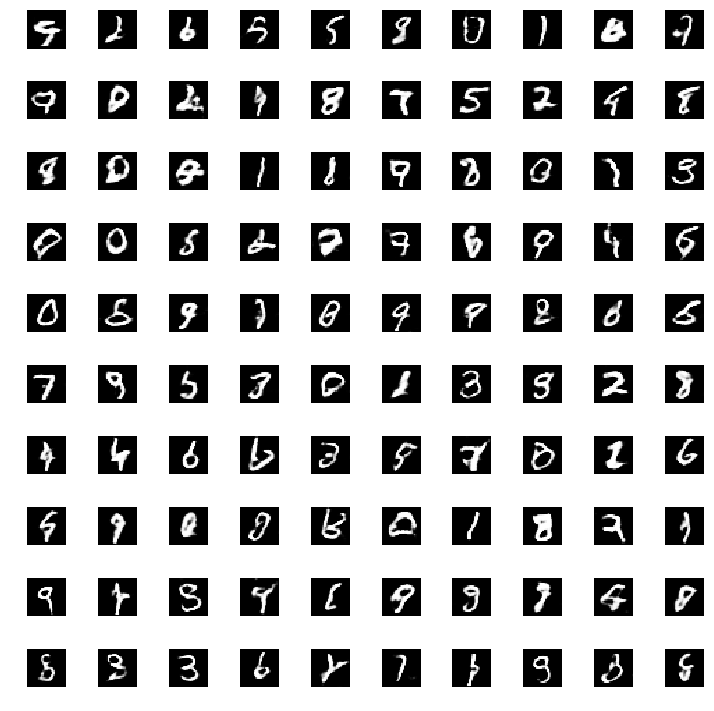

In [91]:
generator.save_weights('gen_30_scaled_images.h5')
discriminator.save_weights('dis_30_scaled_images.h5')
plot_output()

In [92]:
train(20, 128)

100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.19it/s]


discriminator loss : 0.567224, adversarial loss : 1.094871


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 25.75it/s]


discriminator loss : 0.572615, adversarial loss : 1.111115


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 27.07it/s]


discriminator loss : 0.596033, adversarial loss : 1.140306


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 25.47it/s]


discriminator loss : 0.535754, adversarial loss : 1.422347


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 26.17it/s]


discriminator loss : 0.522605, adversarial loss : 1.070317


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 25.53it/s]


discriminator loss : 0.608716, adversarial loss : 0.705379


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 25.50it/s]


discriminator loss : 0.587726, adversarial loss : 1.176992


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.28it/s]


discriminator loss : 0.534104, adversarial loss : 1.114697


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.78it/s]


discriminator loss : 0.584491, adversarial loss : 1.086944


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.55it/s]


discriminator loss : 0.540047, adversarial loss : 0.947892


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.00it/s]


discriminator loss : 0.543007, adversarial loss : 1.221245


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.42it/s]


discriminator loss : 0.549106, adversarial loss : 1.229083


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.60it/s]


discriminator loss : 0.516732, adversarial loss : 1.209057


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.20it/s]


discriminator loss : 0.582106, adversarial loss : 0.894148


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.67it/s]


discriminator loss : 0.565363, adversarial loss : 1.174258


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 25.92it/s]


discriminator loss : 0.596129, adversarial loss : 0.960227


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.29it/s]


discriminator loss : 0.576031, adversarial loss : 0.997796


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.41it/s]


discriminator loss : 0.581997, adversarial loss : 0.997022


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.33it/s]


discriminator loss : 0.536323, adversarial loss : 1.373889


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.24it/s]


discriminator loss : 0.532068, adversarial loss : 0.765644


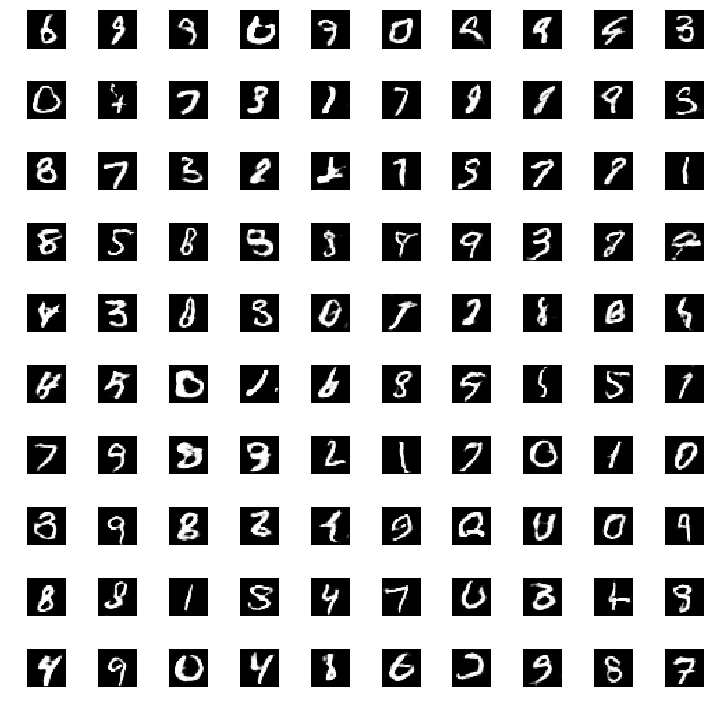

In [93]:
generator.save_weights('gen_50_scaled_images.h5')
discriminator.save_weights('dis_50_scaled_images.h5')
plot_output()

In [61]:
generator.load_weights('gen_50_scaled_images.h5')
discriminator.load_weights('dis_50_scaled_images.h5')